# NHANES - PAD
## Jupyter Example with Python
### This example illustrates fitting and comparing Machine Learning algorithms

#### National Health and Nutrition Examination Survey (NHANES) - Peripheral Artery Disease (PAD)    

#### Data collection:
Household screener, interview, and physical examination

#### Objectives:    
  Understand the survey data and create a predictive model to identify the
  main factors that are related to the disease. The model can also be     
  useful to prioritize the physical exams and to support the diagnostics. 

#### Activities:                                                              
  - Start the session                                                     
  - Prepare the data for Modelling
  - Data Partition (Training and Validation) 
  - Feature Engineering (add additional features)                                                   
  - Modelling                                                             
  - Scoring

In [1]:
## Start the session and prepare the environment
import swat
import os
import pandas as pd
import matplotlib.pyplot as plt
from IPython.core.display import display, HTML
from swat.render import render_html #to visualize model results
%matplotlib inline

# Connect to CAS (this depends on the environment configuration)
conn = swat.CAS(
    hostname = ["link_to_your_host"],
    port = XXX,username="user",password="password")

# CAS Server connection details
#out = conn.serverstatus()
#print(out)

In [2]:
### Import action sets
conn.loadactionset(actionset="dataStep")
conn.loadactionset(actionset="dataPreprocess")
conn.loadactionset(actionset="cardinality")
conn.loadactionset(actionset="sampling")
conn.loadactionset(actionset="decisionTree")
conn.loadactionset(actionset="astore")
conn.loadactionset(actionset="percentile")

NOTE: Added action set 'dataStep'.
NOTE: Added action set 'dataPreprocess'.
NOTE: Added action set 'cardinality'.
NOTE: Added action set 'sampling'.
NOTE: Added action set 'decisionTree'.
NOTE: Added action set 'astore'.
NOTE: Added action set 'percentile'.


[actionset]

 'percentile'

+ Elapsed: 0.00906s, user: 0.00216s, sys: 0.00995s, mem: 0.83mb

In [3]:
## Prepare the data for Modelling
conn.upload('path_to_data_folder/nhanes_nof.sas7bdat')

NOTE: Cloud Analytic Services made the uploaded file available as table NHANES_NOF in caslib CASUSER(sasadm).
NOTE: The table NHANES_NOF has been created in caslib CASUSER(sasadm) from binary data uploaded to Cloud Analytic Services.


[caslib]

 'CASUSER(sasadm)'

[tableName]

 'NHANES_NOF'

[casTable]

 CASTable('NHANES_NOF', caslib='CASUSER(sasadm)')

+ Elapsed: 0.432s, user: 0.0764s, sys: 0.158s, mem: 34.4mb

In [4]:
## Assign variable to the table and check the columns
abt=conn.CASTable(name='NHANES_NOF', caslib='CASUSER(sasadm)')
#conn.columnInfo(table=abt)

In [5]:
## Create the target variable
conn.runCode(code="""
    data CASUSER.NHANES_PAD1 promote; 
    set CASUSER.NHANES_NOF;
            if LEXRABPI = . then LEXRABPI = LEXLABPI;
            if ((LEXLABPI < 0.9) OR (LEXRABPI< 0.9 )) then PAD_Target = 1;
                else PAD_Target = 0;
run;
""")

[InputCasTables]

             casLib        Name  Rows  Columns                                          casTable
 0  CASUSER(sasadm)  NHANES_NOF  6929       47  CASTable('NHANES_NOF', caslib='CASUSER(sasadm)')

[OutputCasTables]

             casLib         Name  Rows  Columns  Append Promoted                                           casTable
 0  CASUSER(sasadm)  NHANES_PAD1  6929       48     NaN        N  CASTable('NHANES_PAD1', caslib='CASUSER(sasadm)')
 1  CASUSER(sasadm)      promote  6929       48     NaN        N      CASTable('promote', caslib='CASUSER(sasadm)')

+ Elapsed: 0.291s, user: 0.0913s, sys: 0.167s, mem: 28mb

In [6]:
## Reassign variable to the table and check the columns
abt=conn.CASTable(name='NHANES_PAD1', caslib='CASUSER')
#conn.columnInfo(table=abt)

In [7]:
## Data Partition (Training and Validation)
conn.sampling.srs(
     table = abt,
     samppct = 30,
     partind = True,
     output = dict(casout = dict(name = 'abt_part', replace = True), copyVars = 'ALL')
)
conn.CASTable('abt_part').freq(inputs='PAD_Target')

NOTE: Simple Random Sampling is in effect.
NOTE: Using SEED=1414455854 for sampling.


,Column,NumVar,FmtVar,Level,Frequency
0,PAD_Target,0.0,0,1,6470.0
1,PAD_Target,1.0,1,2,459.0


In [8]:
## Feature Engineering (add additional features)
conn.runCode(code="""
    data CASUSER.NHANES_PAD1(replace=yes); 
    set CASUSER.abt_part; 
            PulsePreassure = BPXSAR - BPXDAR;
            TC_HDL = LBXTC / LBDHDL;
            IF ((DIQ010 In ('Yes','Borderline')) OR (DIQ050 In ('Yes')) OR (LBXGH > 6.5))
                   then Diabetes = 1;
                   else Diabetes = 0;
            IF ( BPXSAR >= 140 OR BPXDAR >= 90 ) 
                   then Hypertension = 1; 
                   else Hypertension = 0;
    run;
""")
abt_pf=conn.CASTable(name='NHANES_PAD1', caslib='CASUSER')
#conn.columnInfo(table=abt_pf)

NOTE: Missing values were generated as a result of performing an operation on missing values.
      Each place is given by: (Number of times) at (Line):(Column).
      48 at 0:107   99 at 0:144
      41 at 0:107    103 at 0:144
      63 at 0:107    111 at 0:144
NOTE: Duplicate messages output by DATA step:
NOTE: Missing values were generated as a result of performing an operation on missing values.  (occurred 3 times)
      Each place is given by: (Number of times) at (Line):(Column).  (occurred 3 times)


In [9]:
## Modelling
# Specify the data set inputs and target 
interval_inputs = ['RIDAGEMN_Recode', 'PulsePreassure', 'BMXBMI', 'TC_HDL', 'LBXGH', 'Diabetes', 'Hypertension']
class_inputs = ['INDHHINC', 'DMDEDUC2', 'RIDRETH1', 'DIQ150', 'DIQ110', 'SMQ040', 'ALQ100', 'RIAGENDR']
class_vars   = ['INDHHINC', 'DMDEDUC2', 'RIDRETH1', 'DIQ150', 'DIQ110', 'SMQ040', 'ALQ100', 'RIAGENDR', 'PAD_Target']
target       = 'PAD_Target'

In [10]:
# Specify a generic cut-off
Gen_cutoff = 0.5

In [11]:
gb = conn.decisionTree.gbtreeTrain(
    table={"name":abt_pf, "where":"strip(put(_PartInd_, best.))='0'"},
    target=target,
    inputs=class_inputs + interval_inputs,
    nominals=class_vars,
    nTree=150,  m=7,  lasso=0.777,  learningrate=1,  subsamplerate=0.883,  ridge=6.03,  seed=1634211770,
    leafsize=5,  maxbranch=2,  binorder=True,  encodename=True,  mergebin=True,  nBins=20,  maxLevel=6,
    varImp=True,  missing="USEINSEARCH",
    casOut={"name":"gb_model", "replace":True}
)

In [12]:
# Output model statistics
render_html(gb)

Decision Tree for NHANES_PAD1 
 Analysis Variable 
 Importance 
 Std 
 Count 
 
 
 INDHHINC 1.0269520699 2.1867208776 505 
 RIDAGEMN_Recode 0.8730783408 6.4782277548 304 
 PulsePreassure 0.5064843554 1.1654919978 399 
 BMXBMI 0.4975143589 0.8839628693 414 
 TC_HDL 0.4851795726 1.0263028907 430 
 LBXGH 0.463693539 0.8823927015 376 
 SMQ040 0.3637655607 2.1579940124 149 
 DMDEDUC2 0.3379145309 0.7056114026 260 
 RIDRETH1 0.2985500822 1.0016570844 192 
 DIQ150 0.1674961201 0.8626071012 125 
 DIQ110 0.1604200599 0.3233105761 180 
 RIAGENDR 0.0633082012 0.1814010498 48 
 ALQ100 0.0557084372 0.1613893225 71 
 Diabetes 0.0469505021 0.1756860513 39 
 Hypertension 0.0318877837 0.1678827969 26 
 
 
 
 
 Gradient Boosting Tree for NHANES_PAD1 
 Descr 
 Value 
 
 
 Number of Trees 150 
 Distribution 2 
 Learning Rate 1 
 Subsampling Rate 0.883 
 Number of Selected Variables (M) 7 
 Number of Bins 20 
 Number of Variables 15 
 Max Number of Tree Nodes 63 
 Min Number of Tree Nodes 21 
 Max Number of Branches 2 
 Min Number of Branches 2 
 Max Number of Levels 6 
 Min Number of Levels 6 
 Max Number of Leaves 32 
 Min Number of Leaves 11 
 Maximum Size of Leaves 2179 
 Minimum Size of Leaves 5 
 Random Number Seed 1634211770 
 Lasso (L1) penalty 0.777 
 Ridge (L2) penalty 6.03 
 Actual Number of Trees 150 
 Average number of Leaves 24.453333333 
 
 
 
 
 Output CAS Tables 
 CAS Library 
 Name 
 Number of Rows 
 Number of Columns 
 Table 
 
 
 CASUSER(sasadm) gb_model 7186 47 CASTable('gb_model', caslib='CASUSER(sasadm)')

In [13]:
## Scoring
conn.decisionTree.gbtreeScore(
     table={"name":abt_pf},
     modelTable={"name":"gb_model"},
     casOut={"name":'scored_gb', "replace":True},
     copyVars={"PAD_Target", "_PartInd_"},
     encodename = True,
     assessonerow = True
)

[EncodedName]

         LEVNAME  LEVINDEX        VARNAME
 0             1         0  P_PAD_Target1
 1             0         1  P_PAD_Target0

[EncodedTargetName]

   LEVNAME  LEVINDEX       VARNAME
 0                 0  I_PAD_Target

[ErrorMetricInfo]

      TreeID  Trees  NLeaves       MCR   LogLoss       ASE      RASE     MAXAE
 0       0.0    1.0     29.0  0.066243  0.222444  0.061337  0.247663  0.969904
 1       1.0    2.0     56.0  0.068985  0.205645  0.056629  0.237968  0.985768
 2       2.0    3.0     85.0  0.066099  0.197244  0.054045  0.232475  0.992778
 3       3.0    4.0    115.0  0.065233  0.191524  0.052455  0.229031  0.996211
 4       4.0    5.0    139.0  0.062491  0.187500  0.051015  0.225866  0.997660
 5       5.0    6.0    165.0  0.062780  0.184894  0.050069  0.223761  0.998634
 6       6.0    7.0    191.0  0.060182  0.180362  0.048959  0.221267  0.998192
 7       7.0    8.0    219.0  0.059749  0.177588  0.047930  0.218929  0.998554
 8       8.0    9.0    248.0  0.059460  0.174819  0.047168  0.217183  0.999170
 9       9.0   10.0    277.0  0.058594  0.171972  0.046400  0.215408  0.999454
 10     10.0   11.0    308.0  0.059460  0.170573  0.046049  0.214591  0.999230
 11     11.0   12.0    336.0  0.058594  0.169187  0.045464  0.213223  0.999145
 12     12.0   13.0    367.0  0.057295  0.165799  0.044540  0.211045  0.999145
 13     13.0   14.0    395.0  0.054409  0.161662  0.043264  0.207999  0.999323
 14     14.0   15.0    425.0  0.054120  0.159329  0.042875  0.207064  0.998952
 15     15.0   16.0    455.0  0.053110  0.157349  0.042143  0.205287  0.999320
 16     16.0   17.0    482.0  0.051234  0.155376  0.041243  0.203084  0.999598
 17     17.0   18.0    513.0  0.049935  0.153138  0.040384  0.200957  0.999615
 18     18.0   19.0    542.0  0.047626  0.150591  0.039695  0.199236  0.999729
 19     19.0   20.0    570.0  0.049213  0.149270  0.039281  0.198193  0.999703
 20     20.0   21.0    601.0  0.046904  0.146976  0.038584  0.196428  0.999817
 21     21.0   22.0    631.0  0.047337  0.145498  0.037889  0.194650  0.999852
 22     22.0   23.0    660.0  0.045894  0.143604  0.037212  0.192904  0.999852
 23     23.0   24.0    690.0  0.044884  0.142940  0.036844  0.191947  0.999887
 24     24.0   25.0    719.0  0.045172  0.141532  0.036352  0.190661  0.999874
 25     25.0   26.0    751.0  0.044595  0.139996  0.035807  0.189226  0.999807
 26     26.0   27.0    776.0  0.043441  0.139556  0.035521  0.188470  0.999807
 27     27.0   28.0    807.0  0.042719  0.139319  0.035184  0.187573  0.999882
 28     28.0   29.0    835.0  0.042142  0.137599  0.034493  0.185723  0.999888
 29     29.0   30.0    860.0  0.041564  0.137989  0.034574  0.185940  0.999926
 30     30.0   31.0    892.0  0.041564  0.136928  0.034123  0.184725  0.999952
 31     31.0   32.0    921.0  0.041853  0.135508  0.033600  0.183303  0.999950
 32     32.0   33.0    951.0  0.040987  0.133716  0.033083  0.181888  0.999950
 33     33.0   34.0    979.0  0.040699  0.132463  0.032428  0.180079  0.999922
 34     34.0   35.0   1009.0  0.040121  0.133025  0.032434  0.180094  0.999941
 35     35.0   36.0   1039.0  0.039544  0.133246  0.032382  0.179950  0.999935
 36     36.0   37.0   1069.0  0.038822  0.131738  0.031891  0.178581  0.999949
 37     37.0   38.0   1097.0  0.037090  0.131328  0.031584  0.177719  0.999939
 38     38.0   39.0   1125.0  0.036802  0.130816  0.031310  0.176946  0.999953
 39     39.0   40.0   1155.0  0.036658  0.130863  0.031069  0.176264  0.999962
 40     40.0   41.0   1186.0  0.035792  0.129383  0.030581  0.174875  0.999962
 41     41.0   42.0   1216.0  0.035070  0.128730  0.030361  0.174244  0.999961
 42     42.0   43.0   1245.0  0.036225  0.128473  0.030146  0.173627  0.999969
 43     43.0   44.0   1272.0  0.034204  0.127754  0.029776  0.172558  0.999954
 44     44.0   45.0   1302.0  0.034493  0.127370  0.029494  0.171739  0.999938
 45     45.0   46.0   1331.0  0.033338  0.126848  0.029215  0.170923  0.999952
 46     46.0   47.0   1360.0  0.03

In [14]:
assessed = conn.percentile.assess(
     table = 'scored_gb',
     inputs = 'P_PAD_Target1',
     casout = dict(name = 'assessed', replace = True),
     response = target,
     event = '1'
)

In [15]:
assess_ROC_gb  = conn.CASTable('assessed_ROC')
assess_Lift_gb = conn.CASTable('assessed')

In [16]:
ROC_pandas_gb  = assess_ROC_gb.to_frame()
Lift_pandas_gb = assess_Lift_gb.to_frame()

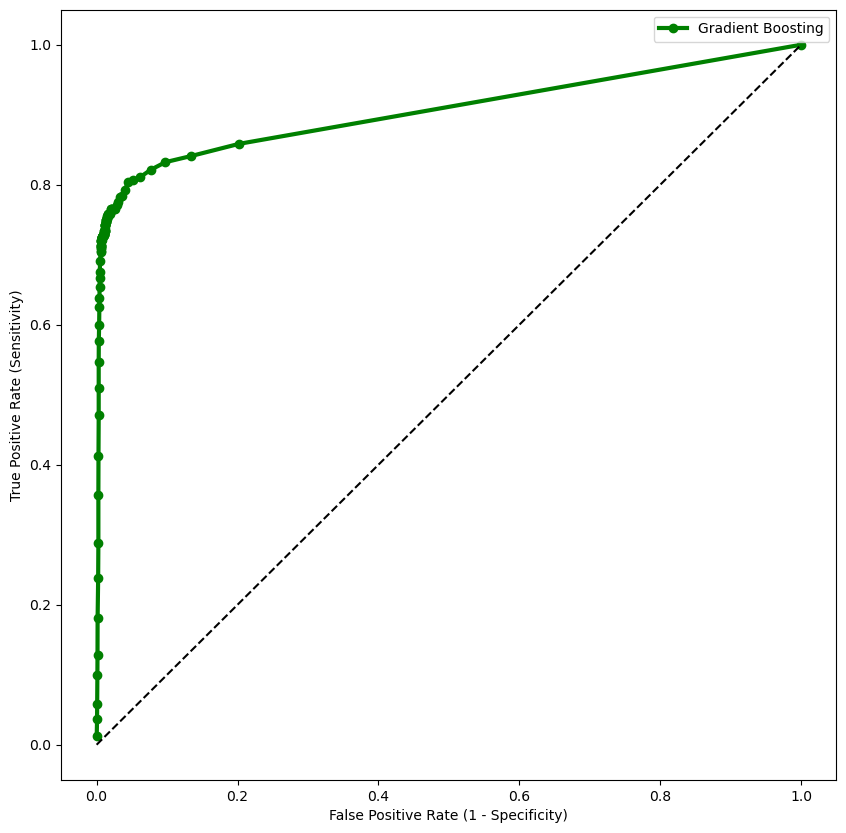

In [17]:
# Plot ROC
plt.figure(figsize = (10,10))
plt.plot(1-ROC_pandas_gb['_Specificity_'], 
           ROC_pandas_gb['_Sensitivity_'], 'go-', linewidth = 3)
plt.plot(pd.Series(range(0,11,1))/10, pd.Series(range(0,11,1))/10, 'k--')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.legend(['Gradient Boosting'])
plt.show()

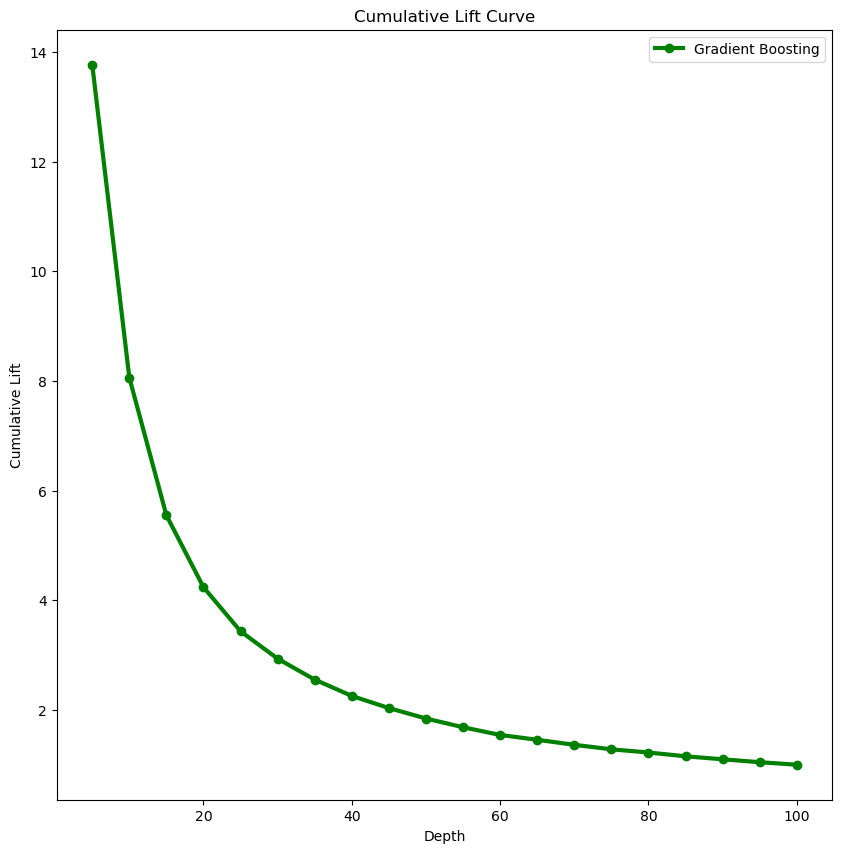

In [18]:
# Plot Lift Locally
plt.figure(figsize = (10,10))
plt.plot(Lift_pandas_gb['_Depth_'], Lift_pandas_gb['_CumLift_'], 'go-', linewidth = 3)
plt.xlabel('Depth')
plt.ylabel('Cumulative Lift')
plt.title('Cumulative Lift Curve')
plt.legend(['Gradient Boosting'])
plt.show()

In [19]:
conn.session.endSession()

+ Elapsed: 0.0063s, user: 0.00643s, sys: 0.00512s, mem: 0.851mb